In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor

import warnings
# Suppress specific FutureWarnings from seaborn
warnings.filterwarnings("ignore", category=FutureWarning)

# About the Dataset

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:

- **Crim** - Per capita name rate by town
- **ZN**  - Propertion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS** - Propertion of non-retail business acres per town
- **CHAS** - Charles River dummy variable (1 if tarct bound river; 0 otherwise )
- **NOX** - Nitric oxides concentration (parts per 10 million)
- **RM** - Average number of rooms per dwelling.
- **AGE** - Propertion of owner-occupied units built prior to 1940
- **DIS** - Weighted distance to five Boston employment centers.
- **RAD** - Index of accessibility of radial highways.
- **TAX** - Full-value property-tax rate per $10,000.
- **PTRATIO** - Pupil-teacher ratio by town.
- **B** - This is calculated as 1000(Bk - 0.63)^2, where Bk is the proportion of black by town.
- **LSTAT** - Percentage lower status of the population.
- **MEDV** - Median value of owner-occupied homes in 1000 dollar's and is often the **Target** variable in regression problem.

In [2]:
## Load the dataset
df=pd.read_csv('HousingData.csv')
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [3]:
# Copy of original data
df_original = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


### Checking missing values

In [5]:
z=df.isnull().sum()[df.isnull().sum()>0].to_frame().rename(columns={0:'Null Values'})
z['% of null values']=z['Null Values']/df.shape[0]*100
z

,Null Values,% of null values
CRIM,20,3.952569
ZN,20,3.952569
INDUS,20,3.952569
CHAS,20,3.952569
AGE,20,3.952569
LSTAT,20,3.952569


In [6]:
df.duplicated().sum()

0

In [7]:
df.shape

(506, 14)

### Check the outliers using boxplot

In [8]:
cols = df.columns
cols

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

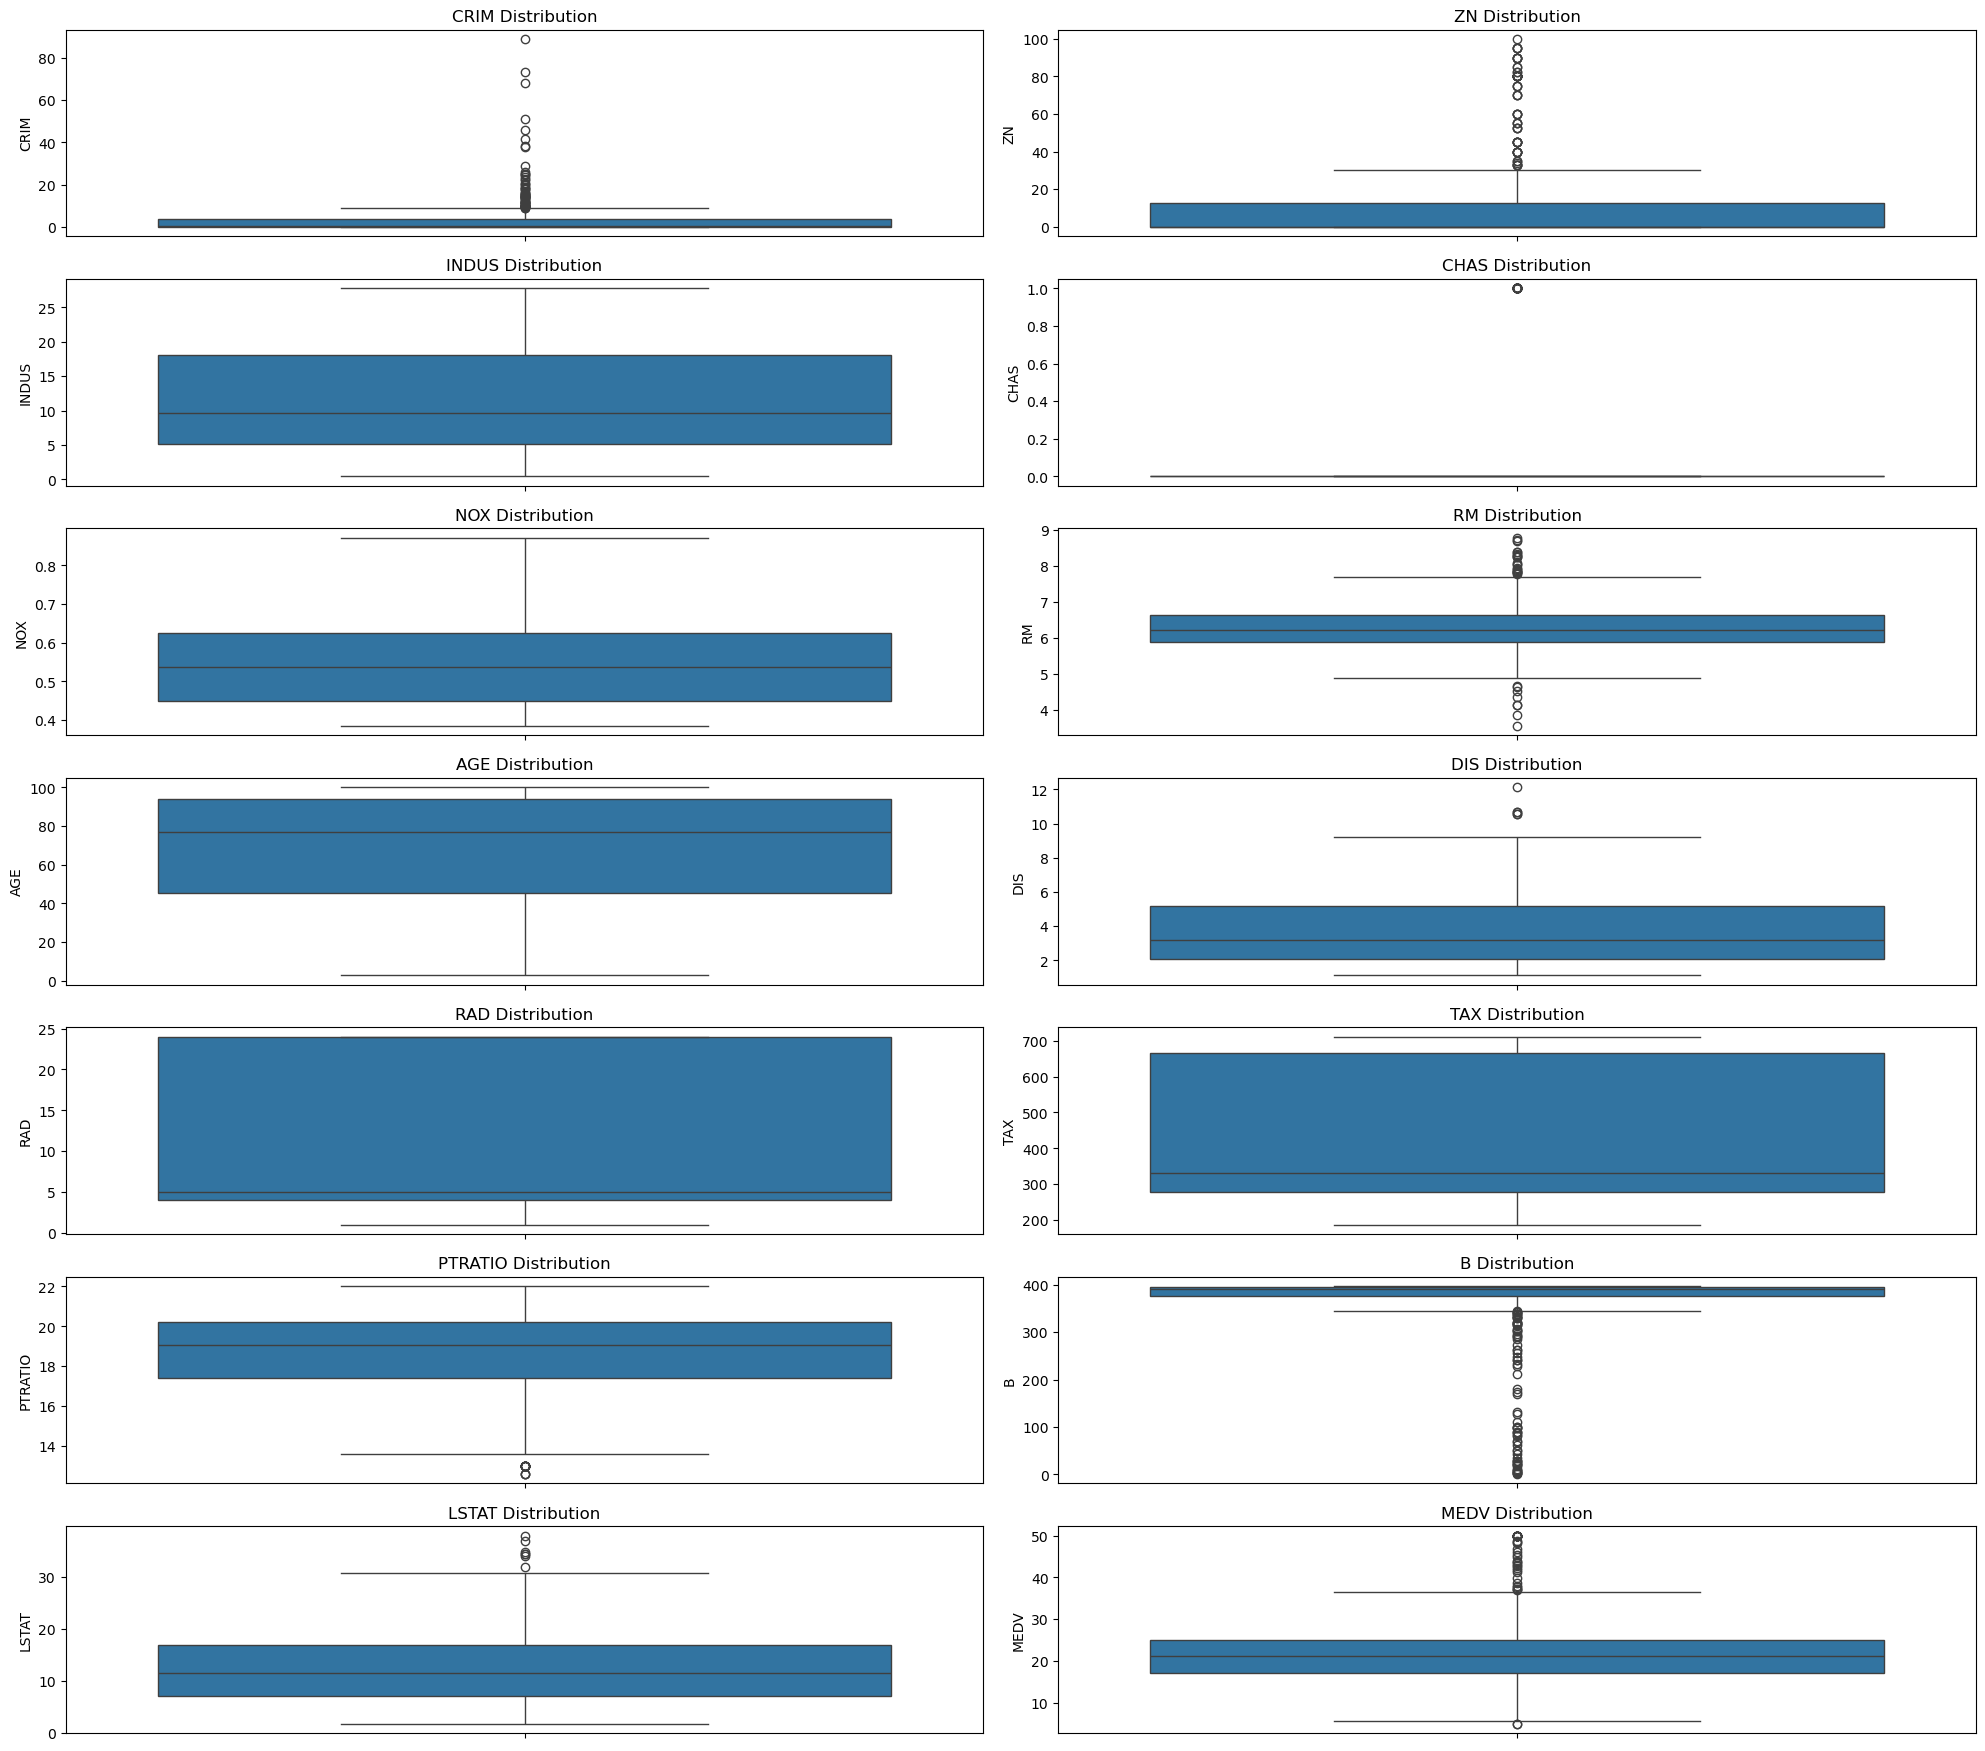

In [9]:
x=1
plt.figure(figsize=(20,35))
for i in cols:
    plt.subplot(14,2,x)
    sns.boxplot(df[i])
    plt.title(F"{i} Distribution")
    x+=1
plt.tight_layout()
plt.show()

 Columns like CRIM, ZN, RM, and B contains many outliers 

### Check the percentages of outliers

In [10]:
for i,j in df.items():
    q1=j.quantile(0.25)
    q3=j.quantile(0.75)
    iqr=q3-q1
    j_col=j[(j<=q1-1.5*iqr) | (j>=q3+1.5*iqr)]
    percentage = np.shape(j_col)[0]*100/np.shape(df)[0]
    print("Column %s outliers = %.2f%%" % (i,percentage))

Column CRIM outliers = 12.85%
Column ZN outliers = 12.45%
Column INDUS outliers = 0.00%
Column CHAS outliers = 96.05%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


### Check skewness of columns using histplot

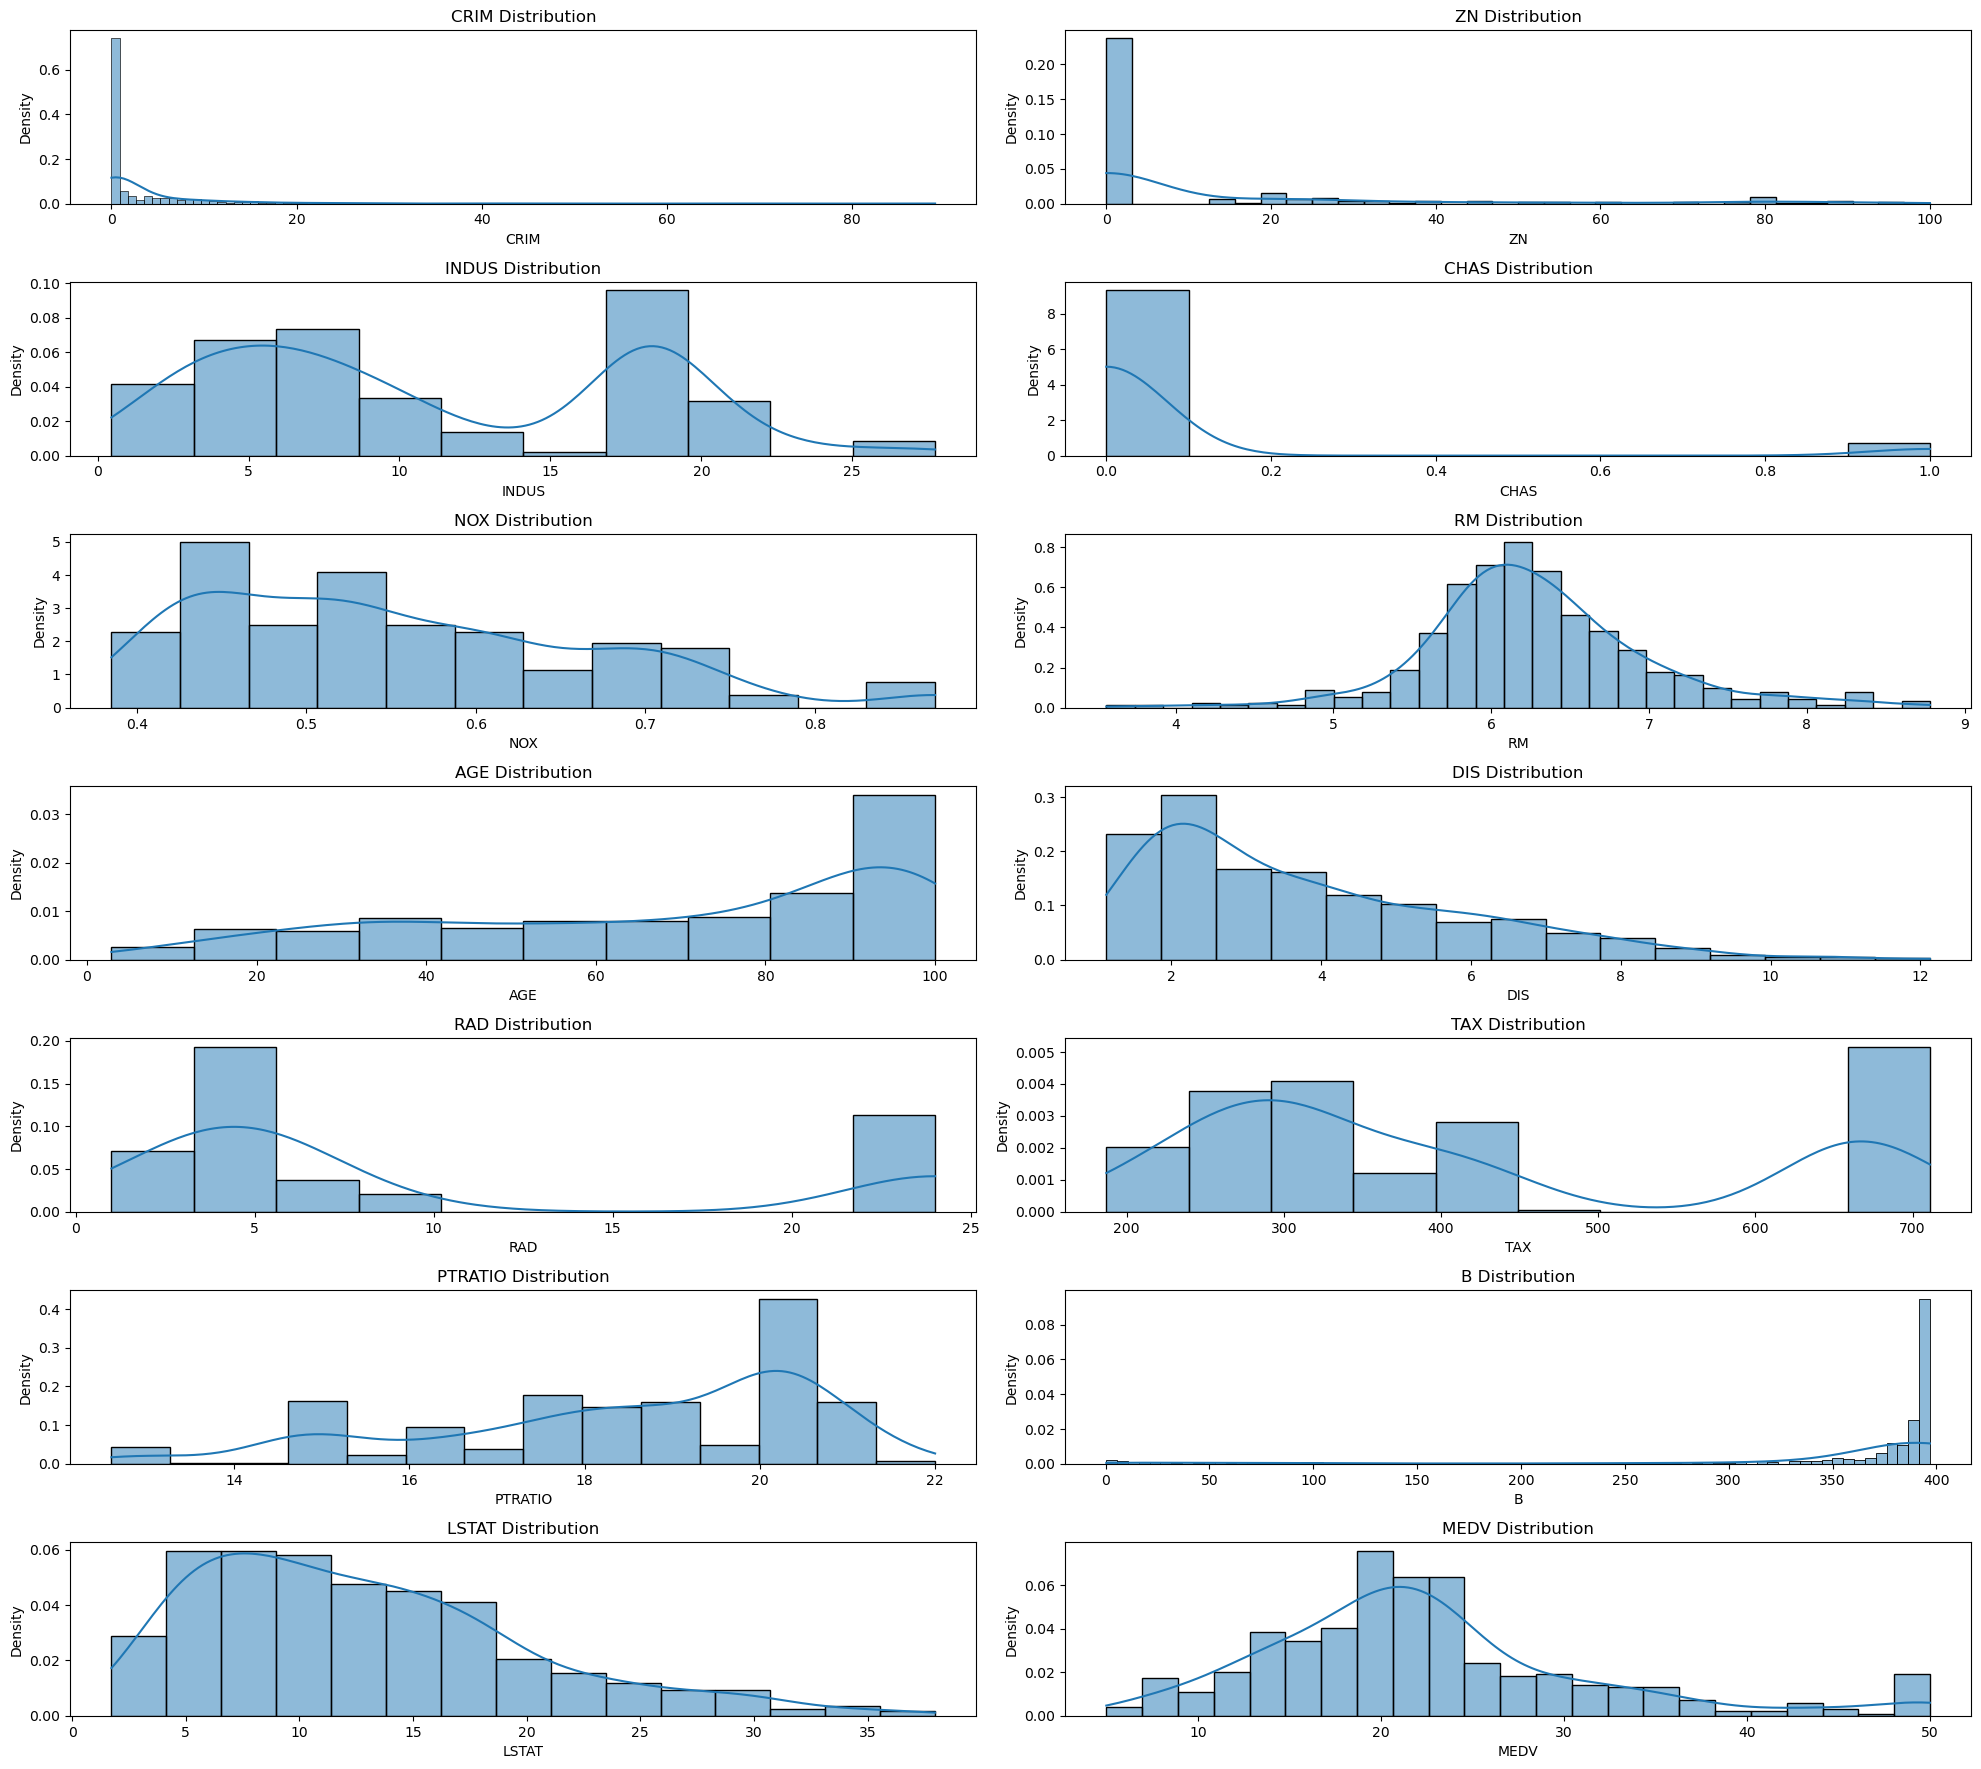

In [11]:
x=1
plt.figure(figsize=(20,35))
for i in cols:
    plt.subplot(14,2,x)
    sns.histplot(df[i],kde=True,stat='density')
    plt.title(F"{i} Distribution")
    x+=1
plt.tight_layout()
plt.show()

The histogram also shows that columns CRIM, ZN, B has highly skewed distributions. Also MEDV looks to have a normal distribution (the predictions) and other colums seem to have norma or bimodel ditribution of data except CHAS (which is a discrete variable).

### Check corelation with MEDV (Target Column)

MEDV       1.000000
RM         0.695360
ZN         0.373136
B          0.333461
DIS        0.249929
CHAS       0.181391
RAD       -0.381626
CRIM      -0.391363
AGE       -0.394656
NOX       -0.427321
TAX       -0.468536
INDUS     -0.481772
PTRATIO   -0.507787
LSTAT     -0.735822
Name: MEDV, dtype: float64


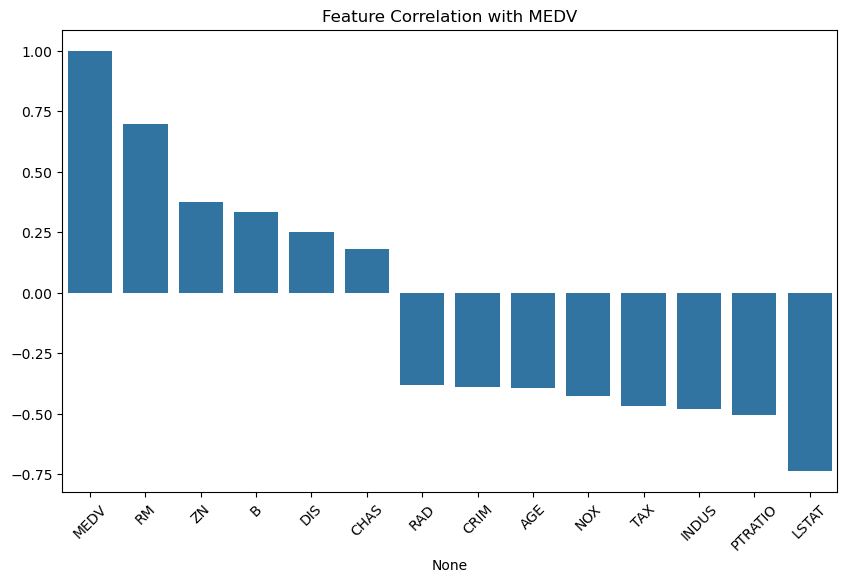

In [12]:
correlation = df.corr()['MEDV'].sort_values(ascending=False)
print(correlation)

# Visualize correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.xticks(rotation=45)
plt.title("Feature Correlation with MEDV")
plt.show()

## Handle Missing Values

In [13]:
# Filling missing values with median because the data contain outliers

df.fillna({'CRIM':df['CRIM'].median()},inplace=True)
df.fillna({'ZN':df['ZN'].median()},inplace=True)
df.fillna({'INDUS':df['INDUS'].median()},inplace=True)
df.fillna({'AGE':df['AGE'].median()},inplace=True)
df.fillna({'LSTAT':df['LSTAT'].median()},inplace=True)

df.fillna({'CHAS':df['CHAS'].mode()[0]},inplace=True) # Bcs it is binary categorical variable(0 or 1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


# Apply Log Transformation for highly skewd features

In [15]:
df['CRIM'] = np.log1p(df['CRIM'])
df['ZN'] = np.log1p(df['ZN'])
df['B'] = np.log1p(df['B'])

## Standardize numeric features AND Selecting features for model training

In [16]:
scaler=StandardScaler()
X = df.drop(columns='MEDV')
X_scaled=scaler.fit_transform(X)
y=df['MEDV']

### Splitting the data

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

In [18]:
## Check the shape

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


# Model Building

## 1. Linear Regression Model

In [19]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [20]:
# Prediction for train and test data
y_train_pred_lr=lr.predict(X_train)
y_test_pred_lr=lr.predict(X_test)

In [21]:
# Evaluate the model

mse=mean_squared_error(y_test,y_test_pred_lr)
rmse=np.sqrt(mse)

# Training data
train_r2_score_lr=r2_score(y_train,y_train_pred_lr)

# Testing data
test_r2_score_lr=r2_score(y_test,y_test_pred_lr)

print("MSE:", mse)
print("RMSE:", rmse)
print(f"Linear Regression Training R2 Score: {train_r2_score_lr}")
print(f"Linear Regression Testing R2 Score: {test_r2_score_lr}")

MSE: 24.88610421325273
RMSE: 4.988597419440932
Linear Regression Training R2 Score: 0.7366608206955867
Linear Regression Testing R2 Score: 0.6606461150538694


## 2. Decesion Tree Regressor

In [22]:
dt = DecisionTreeRegressor(max_depth=3) 
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3)

In [23]:
# Prediction for train and test data
y_train_pred_dt=dt.predict(X_train)
y_test_pred_dt=dt.predict(X_test)

In [24]:
# Evaluate the model

mse=mean_squared_error(y_test,y_test_pred_dt)
rmse=np.sqrt(mse)

# Training data
train_r2_score_dt=r2_score(y_train,y_train_pred_dt)

# Testing data
test_r2_score_dt=r2_score(y_test,y_test_pred_dt)

print("MSE:", mse)
print("RMSE:", rmse)
print(f"Decesion Tree Training R2 Score: {train_r2_score_dt}")
print(f"Decesion Tree Testing R2 Score: {test_r2_score_dt}")

MSE: 20.1103639635588
RMSE: 4.484458045690561
Decesion Tree Training R2 Score: 0.7929024463509364
Decesion Tree Testing R2 Score: 0.7257694462647134


## 3. Random Forest Regressor

In [25]:
rf = RandomForestRegressor(max_depth=5)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

In [26]:
# Prediction for train and test data
y_train_pred_rf=rf.predict(X_train)
y_test_pred_rf=rf.predict(X_test)

In [27]:
# Evaluate the model

mse=mean_squared_error(y_test,y_test_pred_rf)
rmse=np.sqrt(mse)

# Training data
train_r2_score_rf=r2_score(y_train,y_train_pred_rf)

# Testing data
test_r2_score_rf=r2_score(y_test,y_test_pred_rf)

print("MSE:", mse)
print("RMSE:", rmse)
print(f"Random Forest Training R2 Score: {train_r2_score_rf}")
print(f"Random Forest Testing R2 Score: {test_r2_score_rf}")

MSE: 9.806590742107206
RMSE: 3.131547659242504
Random Forest Training R2 Score: 0.9242018661031922
Random Forest Testing R2 Score: 0.8662745828799265


## 4. Support Vector Regressor

In [28]:
sv=SVR()
sv.fit(X_train,y_train)

SVR()

In [29]:
# Prediction for train and test data
y_train_pred_svr=sv.predict(X_train)
y_test_pred_svr=sv.predict(X_test)

In [30]:
# Evaluate the model

mse=mean_squared_error(y_test,y_test_pred_svr)
rmse=np.sqrt(mse)

# Training data
train_r2_score_svr=r2_score(y_train,y_train_pred_svr)

# Testing data
test_r2_score_svr=r2_score(y_test,y_test_pred_svr)

print("MSE:", mse)
print("RMSE:", rmse)
print(f"Support Vector Training R2 Score: {train_r2_score_svr}")
print(f"Support Vector Testing R2 Score: {test_r2_score_svr}")

MSE: 22.808491993689092
RMSE: 4.775823697927834
Support Vector Training R2 Score: 0.6888156834545017
Support Vector Testing R2 Score: 0.6889770169933145


# Hyper-Parameter Tunning on Linear Regression

In [31]:
# Define Ridge and Lasso models
ridge = Ridge()
lasso = Lasso()

# Hyperparameter grid
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 20]}
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 20]}

# Grid Search for Ridge
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)

# Grid Search for Lasso
grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)

# Best parameters and score
print("Best Ridge Parameters:", grid_ridge.best_params_)
print("Best Ridge Score:", grid_ridge.best_score_)
print("Best Lasso Parameters:", grid_lasso.best_params_)
print("Best Lasso Score:", grid_lasso.best_score_)

Best Ridge Parameters: {'alpha': 10}
Best Ridge Score: 0.7077415195253207
Best Lasso Parameters: {'alpha': 0.01}
Best Lasso Score: 0.7063282507722112


# Hyper-Parameter Tunning on Decesion Tree Regression

In [32]:
# Define the model
decision_tree = DecisionTreeRegressor()

# Hyperparameter grid
param_grid_dtr = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Grid Search
grid_dtr = GridSearchCV(decision_tree, param_grid_dtr, cv=5, scoring='r2')
grid_dtr.fit(X_train, y_train)

# Best parameters and score
print("Best Decision Tree Parameters:", grid_dtr.best_params_)
print("Best Decision Tree Score:", grid_dtr.best_score_)

Best Decision Tree Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Decision Tree Score: 0.6938341780583295


# Hyper-Parameter Tunning on Random Forest Regressor

In [33]:
# Define the model
random_forest = RandomForestRegressor()

# Hyperparameter grid
param_grid_rfr = {
    'n_estimators': [50, 100,200],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Grid Search
grid_rfr = GridSearchCV(random_forest, param_grid_rfr, cv=5, scoring='r2', n_jobs=-1)
grid_rfr.fit(X_train, y_train)

# Best parameters and score
print("Best Random Forest Parameters:", grid_rfr.best_params_)
print("Best Random Forest Score:", grid_rfr.best_score_)


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest Score: 0.8108294907698028


# Hyper-Parameter Tunning on Support Vector Regressor

In [34]:
# Define the model
svr = SVR()

# Hyperparameter grid
param_grid_svr = {
    'C': [0.1, 1, 10, 20],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

# Grid Search
grid_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='r2', n_jobs=-1)
grid_svr.fit(X_train, y_train)

# Best parameters and score
print("Best SVR Parameters:", grid_svr.best_params_)
print("Best SVR Score:", grid_svr.best_score_)

Best SVR Parameters: {'C': 20, 'epsilon': 1, 'kernel': 'rbf'}
Best SVR Score: 0.848915463774188


* **Random Forest Regressor** and  **Support Vector Regressor** is providing the Best Score. So, we will check on these our Test Data

In [35]:
### For Random Forest Regressor

best_model_rfr = grid_rfr.best_estimator_

y_train_pred_rfr = best_model_rfr.predict(X_train)
y_test_pred_rfr = best_model_rfr.predict(X_test)

# Evaluate

mse_rfr = mean_squared_error(y_test, y_test_pred_rfr)
y_train_rfr = r2_score(y_train,y_train_pred_rfr)
y_test_rfr = r2_score(y_test, y_test_pred_rfr)
print(f"Test MSE: {mse_rfr}")
print(f" Random Forest Tunning Train R2 Score: {y_train_rfr} ")
print(f" Random Forest Tunning Test R2 Score: {y_test_rfr} ")

Test MSE: 9.16251911651517
 Random Forest Tunning Train R2 Score: 0.9739957962958312 
 Random Forest Tunning Test R2 Score: 0.8750573239009913 


In [36]:
### For Support Vector Regressor

best_model = grid_svr.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate

mse = mean_squared_error(y_test, y_test_pred)
y_train_r2 = r2_score(y_train,y_train_pred)
y_test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {mse}")
print(f" Support Vector Tunning Train R2 Score: {y_train_r2} ")
print(f" Support Vector Tunning Test R2 Score: {y_test_r2} ")

Test MSE: 12.358955650732955
 Support Vector Tunning Train R2 Score: 0.928921545022629 
 Support Vector Tunning Test R2 Score: 0.8314698203457784 


**Key Observations:**
* Random Forest outperforms Support Vector Regressor based on the Test R² Score (0.8636 vs. 0.8314), even though both models yield the same Test MSE.
* The difference in performance is more evident in R², which accounts for the proportion of variance explained by the model.

# Recommendation:
**Use Random Forest Regressor as the final model.**
* It shows better generalization and explains more variance in the test data compared to Support Vector Regressor